In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim, StatsBase
using Random, Distributions, LoopVectorization
using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
using Plots

In [3]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/HS-Palmer"

In [4]:
local_path = "../../BulkLMM.jl/src";

In [216]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));
include("../../BigRiver_util_code/src/kinship_utils.jl");
include("../../BigRiver_util_code/src/run_gemma_utils.jl");

## Omics traits:

In [152]:
@time omics_pheno_df = CSV.read("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Rat-PL-RSeq-0818_nomissing.csv", DataFrame);

  1.316718 seconds (1.11 M allocations: 84.567 MiB)


In [153]:
names(omics_pheno_df)[1:6]

6-element Vector{String}:
 "id"
 "ENSRNOG00000000001"
 "ENSRNOG00000000007"
 "ENSRNOG00000000008"
 "ENSRNOG00000000009"
 "ENSRNOG00000000010"

In [154]:
sample_ids = omics_pheno_df[:, 1];

In [155]:
omics_pheno = omics_pheno_df[1:end, 2:end] |> Matrix{Float64};

Remove missings or columns of all 0's...

In [156]:
no_value_traits = vec(sum(omics_pheno, dims = 1) .== 0.0);

In [157]:
omics_pheno_processed = omics_pheno[:, map(x -> x .== 0.0, no_value_traits)];

In [158]:
grid_loose = collect(0.0:0.05:0.95);

## HS Genotypes：

In [171]:
count = 0;
test_line = readline("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Palmer_true.geno")

for line in eachline("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Palmer_true.geno")
    
    count = count + 1;
    # println(line)
    
    test_line = line
    
    if count == 9 # data starts from the line 9
        break
    end
    
end

In [172]:
geno_colnames = split(test_line, '\t')

6151-element Vector{SubString{String}}:
 "Chr"
 "Locus"
 "cM"
 "Mb"
 "0007A0008B"
 "0007A00024"
 "0007A000DB"
 "0007A001C5"
 "0007A0059F"
 "0007A00263"
 "0007A00670"
 "0007A00716"
 "0007A01A7C"
 ⋮
 "0007929889"
 "0007929894"
 "0007929913"
 "0007929918"
 "0007929924"
 "0007929944"
 "0007929945"
 "0007929959"
 "0007929963"
 "0007929965"
 "0007929994"
 "0007929999"

In [182]:
@time cols_to_extract_from_fullgeno = map(x -> x in sample_ids, geno_colnames);
cols_to_extract_from_fullgeno[1:4] .= 1; # also want to store information about the markers (the first 4 cols: Chr, Locus, cM, Mb)

  0.095852 seconds (553.54 k allocations: 33.283 MiB, 56.60% compilation time)


In [183]:
sum(cols_to_extract_from_fullgeno)

84

In [184]:
cols_ids_in_geno = findall(cols_to_extract_from_fullgeno .== 1);

In [186]:
@time begin
    myfile = open("my_genofile.txt", "w")
    row_count = 0
    for line in eachline("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Palmer_true.geno")

        row_count = row_count + 1;

        if row_count >= 9
            col_count = 0;
            words_in_curr_line = split(line, '\t');
            for word in words_in_curr_line
                col_count = col_count + 1;
                if col_count in cols_ids_in_geno
                    to_write = word * "\t";
                    write(myfile, to_write);
                end
            end
            write(myfile, "\n")
        end
    end

    close(myfile)
end

146.136487 seconds (819.18 M allocations: 67.304 GiB, 19.32% gc time, 0.00% compilation time)


error in running finalizer: ErrorException("task switch not allowed from inside gc finalizer")
jl_error at /buildworker/worker/package_linux64/build/src/rtutils.c:41
jl_switch at /buildworker/worker/package_linux64/build/src/task.c:483
try_yieldto at ./task.jl:802
wait at ./task.jl:872
wait at ./condition.jl:123
lock at ./lock.jl:100
close at ./iostream.jl:42
_jl_invoke at /buildworker/worker/package_linux64/build/src/gf.c:2247 [inlined]
jl_apply_generic at /buildworker/worker/package_linux64/build/src/gf.c:2429
jl_apply at /buildworker/worker/package_linux64/build/src/julia.h:1788 [inlined]
run_finalizer at /buildworker/worker/package_linux64/build/src/gc.c:278
jl_gc_run_finalizers_in_list at /buildworker/worker/package_linux64/build/src/gc.c:367
run_finalizers at /buildworker/worker/package_linux64/build/src/gc.c:394
jl_gc_run_pending_finalizers at /buildworker/worker/package_linux64/build/src/gc.c:405
jl_mutex_unlock at /buildworker/worker/package_linux64/build/src/julia_locks.h:131

In [198]:
@time omics_geno_full = readdlm("my_genofile.txt", '\t')

 41.105239 seconds (209.62 M allocations: 5.444 GiB, 71.86% gc time)


134919×85 Matrix{Any}:
   "Chr"  "Locus"             "cM"     …   "000789FFF8"   "000789FFF9"  ""
  1       "chr1:55365"       0.055365     2              2              ""
  1       "chr1:666374"      0.666374     2              2              ""
  1       "chr1:666382"      0.666382     2              2              ""
  1       "chr1:666394"      0.666394     2              2              ""
  1       "chr1:669529"      0.669529  …  2              1              ""
  1       "chr1:669562"      0.669562     1              2              ""
  1       "chr1:671466"      0.671466     1              2              ""
  1       "chr1:759319"      0.759319     1.979          0.007          ""
  1       "chr1:1134030"     1.13403      1.993          1.998          ""
  1       "chr1:1139210"     1.13921   …  1.993          1.997          ""
  1       "chr1:1143318"     1.14332      0.01           0.003          ""
  1       "chr1:1151014"     1.15101      1.997          1.998          ""
  

In [200]:
@time omics_geno = readdlm("my_genofile.txt", '\t')[2:end, 5:(end-1)]

 37.660587 seconds (209.62 M allocations: 5.524 GiB, 68.08% gc time)


134918×80 Matrix{Any}:
 2        2        1        2        …  2        1        2        2
 2        2        2        2           2        2        2        2
 2        2        2        1           2        2        2        2
 2        2        2        1           2        2        2        2
 2        2        2        1           2        2        2        1
 2        2        2        2        …  2        2        1        2
 2        2        2        2           2        2        1        2
 0.997    1.976    0.991    1.979       1.979    1.979    1.979    0.007
 1.941    1.559    1.006    1.994       1.993    1.994    1.993    1.998
 1.978    1.992    1.997    1.994       1.993    1.993    1.993    1.997
 0.031    0.39     0.99298  0.008    …  0.01     0.009    0.01     0.003
 1.997    1.997    1.998    1.997       1.997    1.997    1.997    1.998
 1.997    1.997    1.006    1.997       1.997    1.997    1.997    1.998
 ⋮                                   ⋱                  

In [201]:
NA_entries = findall(x -> typeof(x) == SubString{String}, omics_geno)

1494-element Vector{CartesianIndex{2}}:
 CartesianIndex(21302, 1)
 CartesianIndex(21316, 1)
 CartesianIndex(35852, 1)
 CartesianIndex(35855, 1)
 CartesianIndex(78338, 1)
 CartesianIndex(78340, 1)
 CartesianIndex(78341, 1)
 CartesianIndex(78363, 1)
 CartesianIndex(95701, 1)
 CartesianIndex(95704, 1)
 CartesianIndex(95731, 1)
 CartesianIndex(95812, 1)
 CartesianIndex(21302, 2)
 ⋮
 CartesianIndex(95776, 80)
 CartesianIndex(95777, 80)
 CartesianIndex(95779, 80)
 CartesianIndex(95781, 80)
 CartesianIndex(95782, 80)
 CartesianIndex(95784, 80)
 CartesianIndex(95787, 80)
 CartesianIndex(95812, 80)
 CartesianIndex(109662, 80)
 CartesianIndex(124557, 80)
 CartesianIndex(124558, 80)
 CartesianIndex(130075, 80)

There are still some missings coded as "NA"'s...

In [190]:
omics_geno[21302, 1]

2

In [191]:
omics_geno[130075, 80]

0.037

In [192]:
NA_markers = zeros(length(NA_entries));

for i in 1:length(NA_entries)
    NA_markers[i] = NA_entries[i][1];
end

NA_markers = trunc.(Int64, NA_markers);

In [193]:
NA_markers

136412-element Vector{Int64}:
      1
      2
      3
      4
      5
      6
      7
      8
      9
     10
     11
     12
     13
      ⋮
  95776
  95777
  95779
  95781
  95782
  95784
  95787
  95812
 109662
 124557
 124558
 130075

In [194]:
omics_geno_nomissing = omics_geno[map(x -> !(x in NA_markers), collect(1:size(omics_geno, 1))), :]';

In [195]:
writedlm("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Palmer_true_omics_geno_nomissing.txt", omics_geno_nomissing, '\t')

In [196]:
omics_geno_nomissing = float.(omics_geno_nomissing)./2.0;

In [197]:
@time maf_omics_geno = vec(mean(omics_geno_nomissing; dims = 1));

LoadError: MethodError: no method matching zero(::Type{Any})
[0mClosest candidates are:
[0m  zero(::Type{Union{Missing, T}}) where T at ~/Softwares/Julia/julia-1.7.3/share/julia/base/missing.jl:105
[0m  zero([91m::Union{Type{P}, P}[39m) where P<:Dates.Period at ~/Softwares/Julia/julia-1.7.3/share/julia/stdlib/v1.7/Dates/src/periods.jl:53
[0m  zero([91m::OffsetArrays.OffsetArray[39m) at ~/.julia/packages/OffsetArrays/WvkHl/src/OffsetArrays.jl:405
[0m  ...

In [32]:
to_keep = map(x -> (x < 0.95) & (x > 0.05), maf_omics_geno);

In [33]:
omics_geno_processed = omics_geno_nomissing[:, to_keep];

In [34]:
(n, m) = size(omics_pheno_processed);
p = size(omics_geno_processed, 2);

In [35]:
n, m, p

(80, 18416, 117618)

## Load BulkLMM functions:

In [36]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));
include("../../BigRiver_util_code/src/kinship_utils.jl");
include("../../BigRiver_util_code/src/run_gemma_utils.jl");

In [37]:
@time omics_kinship = calcKinship(omics_geno_processed);

  9.149925 seconds (31.60 k allocations: 13.847 GiB, 11.30% gc time)


In [71]:
BLAS.get_num_threads()

8

In [46]:
BLAS.set_num_threads(8)

## BulkLMM:

In [44]:
@time bulkscan_null_grid_results = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_fine;
                                                      reml = false);

 37.428594 seconds (30.33 M allocations: 39.754 GiB, 4.32% gc time, 6.84% compilation time)


In [47]:
# @time bulkscan_alt_grid_results = bulkscan_alt_grid(omics_pheno_nozeros, omics_geno_nomissing_filtered, omics_kinship, grid_loose);

In [41]:
grid_loose = collect(0.00:0.05:0.95);

In [43]:
grid_fine = collect(0.00:0.01:0.99);

## GEMMA:

In [72]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

"/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [74]:
rand_samples = sample(1:m, 10);

In [75]:
rand_samples = [1, 1997]

2-element Vector{Int64}:
    1
 1997

In [76]:
pheno_filename = "data/GEMMA_data/hs_omics_pheno.txt";
geno_filename = "data/GEMMA_data/hs_omics_geno.txt";
kinship_filename = "data/GEMMA_data/hs_omics_kinship.txt";
output_filename = "results_univariate_LMM";

In [77]:
marker_names = "marker: " .* string.(collect(1:p));

In [78]:
@time gemma_samples_results = run_gemma(omics_pheno_processed[:, rand_samples], omics_geno_processed, omics_kinship,
                                        ["A", "B"], marker_names,
                                        pheno_filename, geno_filename, kinship_filename, 
                                        output_filename, 
                                        gemma);

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 80
## number of analyzed individuals = 80
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =   117618
## number of analyzed SNPs         =   117618
Start Eigen-Decomposition...
pve estimate =3.5548e-06
se(pve) =0.633945
================================================== 100%


**** INFO: Done.


GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 80
## number of analyzed individuals = 80
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =   117618
## number of analyzed SNPs         =   117618
Start Eigen-Decomposition...
pve estimate =0.999997
se(pve) =0.000515413
================================================== 100%


**** INFO: Done.


 31.931135 seconds (85.92 M allocations: 5.555 GiB, 18.08% gc time)


In [217]:
test_omics_trait = reshape(omics_pheno_processed[:, 1], :, 1) 
# colStandardize!(test_omics_trait)

80×1 Matrix{Float64}:
 3.6379
 3.7742
 3.554
 3.3301
 3.5547
 3.8215
 3.6407
 3.6343
 3.6807
 3.8224
 3.6883
 3.4971
 3.6853
 ⋮
 3.3328
 3.688
 3.3988
 3.7564
 3.5502
 3.5294
 3.9482
 3.6431
 3.6125
 3.4008
 3.7062
 3.7628

In [113]:
@time gemma_samples_results = run_gemma(test_omics_trait, omics_geno_processed, omics_kinship,
                                        ["A", "B"], marker_names,
                                        pheno_filename, geno_filename, kinship_filename, 
                                        output_filename, 
                                        gemma);

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 80
## number of analyzed individuals = 80
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =   117618
## number of analyzed SNPs         =   117618
Start Eigen-Decomposition...
pve estimate =3.5548e-06
se(pve) =0.633945
================================================== 100%


**** INFO: Done.


 20.828647 seconds (57.08 M allocations: 4.807 GiB, 22.99% gc time)


In [265]:
grid_fine = collect(1:999) .* 0.001;

Loglik plot: 


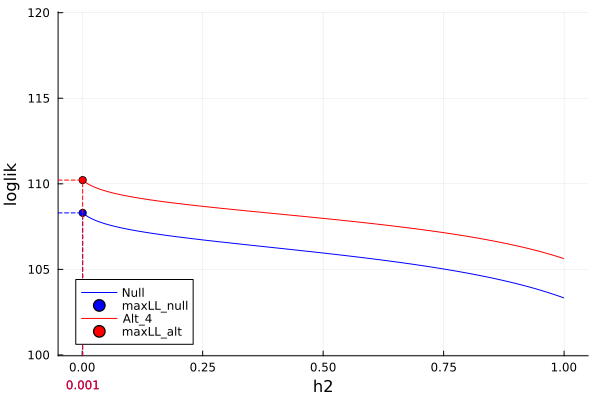

  4.574355 seconds (1.47 M allocations: 929.130 MiB, 81.65% gc time, 0.76% compilation time)


In [267]:
@time scan(test_omics_trait, omics_geno_processed, omics_kinship; 
           reml = true, assumption = "null", optim_interval = 4,
           plot_loglik = true, markerID = 1, h2_grid = grid_fine, y_lims = [100.0, 120.0]);

In [240]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));
include("../../BigRiver_util_code/src/kinship_utils.jl");
include("../../BigRiver_util_code/src/run_gemma_utils.jl");

In [241]:
@time test_trait1 = scan(test_omics_trait, omics_geno_processed, omics_kinship; 
                         reml = false, assumption = "alt");

 87.131079 seconds (195.07 M allocations: 85.923 GiB, 21.81% gc time, 1.39% compilation time)


In [242]:
test_trait1.sigma2_e

0.024522431974999963

In [262]:
temp = "results_univariate_LMM.assoc.txt";
gemma_results = readdlm(joinpath("output/", temp), '\t');
gemma_pvals = gemma_results[2:end, end] |> x -> Array{Float64}(x);
gemma_lods = p2lod.(gemma_pvals, 2);
gemma_lods

117618-element Vector{Float64}:
 0.5214736171774955
 0.7034853034944917
 0.31472862860738493
 0.0852644624126282
 0.26681967351130803
 0.08681569513360746
 0.2307458153430037
 0.5437222013908806
 0.3223870255910424
 0.033272998086556274
 0.3705547208914712
 0.08908635742106671
 0.37233116483008194
 ⋮
 0.2293060561457728
 0.14153468953002862
 0.14146436637452442
 0.14134630442645862
 0.14460157923043332
 0.14153468953002862
 0.08682089304271583
 0.053653570315354254
 0.491058401636849
 0.44244925052634454
 0.3910812465925695
 0.3884976118700445

In [263]:
test_trait1.h2_each_marker

117618-element Vector{Float64}:
 1.783907244156758e-15
 2.34890354044044e-15
 2.34890354044044e-15
 8.4984128456085e-16
 8.4984128456085e-16
 8.4984128456085e-16
 2.34890354044044e-15
 6.277966669721967e-16
 8.97201316153285e-16
 2.34890354044044e-15
 2.34890354044044e-15
 8.4984128456085e-16
 8.4984128456085e-16
 ⋮
 8.4984128456085e-16
 8.97201316153285e-16
 8.4984128456085e-16
 1.4517022242871552e-15
 2.34890354044044e-15
 8.97201316153285e-16
 3.800605764727595e-15
 8.4984128456085e-16
 8.4984128456085e-16
 8.4984128456085e-16
 2.3315148220573175e-15
 8.4984128456085e-16

In [245]:
test_trait1.h2_each_marker[4]

8.4984128456085e-16

In [243]:
hcat(bulkscan_null_grid_results.L[:, 1], test_trait1.lod, gemma_samples_results)

117618×3 Matrix{Float64}:
 0.340197    0.340197    0.232322
 0.391565    0.391565    0.359937
 0.288975    0.288975    0.106136
 0.831917    0.831917    0.0110229
 0.325364    0.325364    0.0811541
 0.697638    0.697638    0.0113947
 0.550568    0.550568    0.063785
 0.495616    0.495616    0.24725
 0.299334    0.299334    0.11031
 0.493727    0.493727    0.00186067
 0.437515    0.437515    0.137586
 0.356815    0.356815    0.0119481
 0.229415    0.229415    0.138624
 ⋮                       
 0.0325104   0.0325104   0.0631203
 1.24786e-5  1.24786e-5  0.0275121
 4.45794e-6  4.45794e-6  0.027488
 8.83031e-6  8.83031e-6  0.0274475
 2.23587e-6  2.23587e-6  0.028572
 1.24786e-5  1.24786e-5  0.0275121
 0.00492947  0.00492947  0.0113959
 0.0847242   0.0847242   0.0046397
 0.146107    0.146107    0.212271
 0.189778    0.189778    0.181163
 0.155139    0.155139    0.149702
 0.157019    0.157019    0.148162

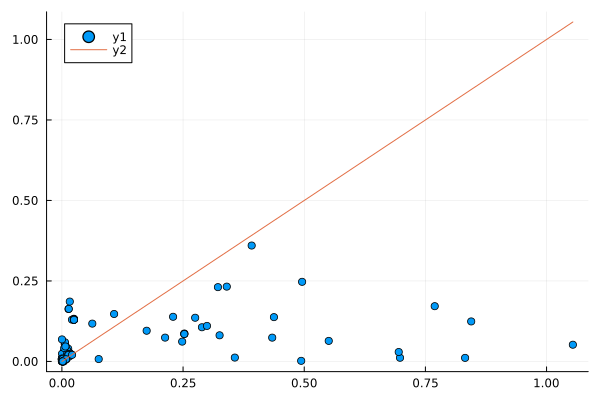

In [215]:
scatter(test_trait1.lod[1:100], gemma_samples_results[1:100])
plot!(x -> x)

In [208]:
findmax(test_trait1.lod[1:100] ./ gemma_samples_results[1:100])

(18153.226713966164, 81)

In [211]:
test_trait1.lod[81] = 0.0

0.0

In [213]:
gemma_samples_results[81] = 0.0

0.0

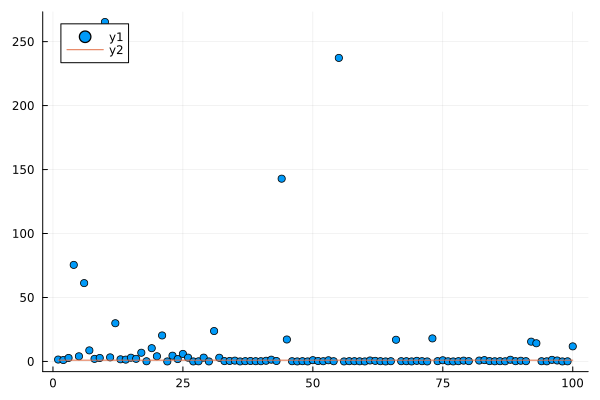

In [214]:
scatter(test_trait1.lod[1:100] ./ gemma_samples_results[1:100])
plot!(x -> 1)

In [258]:
sum(abs.((test_trait1.lod[1:100] ./ gemma_samples_results[1:100]) .- 1.0) .<= 0.1)

4

In [261]:
hcat(test_trait1.lod[findall(abs.((test_trait1.lod[1:100] ./ gemma_samples_results[1:100]) .- 1.0) .<= 0.1)], 
     gemma_samples_results[findall(abs.((test_trait1.lod[1:100] ./ gemma_samples_results[1:100]) .- 1.0) .<= 0.1)])

4×2 Matrix{Float64}:
 0.391565   0.359937
 0.015338   0.0156514
 0.019573   0.021736
 0.0209777  0.0204102

#### Issues with data found so far:

- Identical genotype probabilities at some markers for all samples;